# Introduction

This project builds a neural network of my own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [2]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [3]:
# Install requirements
!python -m pip install -r requirements.txt
!pip install widgetsnbextension
!pip install ipywidgets
!pip install --upgrade jupyter ipywidgets

Defaulting to user installation because normal site-packages is not writeable
  Using cached ipywidgets-7.7.0-py2.py3-none-any.whl (123 kB)
  Using cached widgetsnbextension-3.6.6-py2.py3-none-any.whl (1.6 MB)


  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.10
    Uninstalling widgetsnbextension-4.0.10:
      Successfully uninstalled widgetsnbextension-4.0.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.2
    Uninstalling ipywidgets-8.1.2:
      Successfully uninstalled ipywidgets-8.1.2
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: jupyter in /root/.local/lib/python3.7/site-packages (1.0.0)
  Using cached ipywidgets-8.1.2-py3-none-any.whl (139 kB)
  Using cached widgetsnbextension-4.0.10-py3-none-any.whl (2.3 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.0
    Uninstalling ipywidgets-7.7.0:
      Successfully uninstalled ipywidgets-7.7.0


## Imports

In [4]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specifying my transforms.
The transforms module is already loaded as `transforms`.

MNIST is included in the torchvision module.
I created a dataset `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).


Once my dataset was created, I defined a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader

#Defining transforms
transform = transforms.Compose([
    transforms.ToTensor(),  #Converting the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalising pixel values to the range [-1, 1]
])

#Creating training set and defining training dataloader
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#Creating test set and defining test dataloader
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Justifying my preprocessing



My chosen transforms were data conversion and normalisation.

Used normalisation as it is a commun preprocessing step in deep learning that helps to accelerate training process. It standardises the pixel values of the images to have a mean of 0.5 and a standard deviation of 0.5.

Used data conversion ToTensor() in order to convert the input images into PyTorch tensors. Based on the fact that Neural networks usually operates with numerical data, representing images as tensors allows me to better leverage the computational power of PyTorch.

## Explore the Dataset
Using matplotlib, numpy, and torch, explored the dimensions of my data.


In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [7]:
# Explore data
#Calculating the number of train and test samples
number_train_samples = len(train_dataset)
number_test_samples = len(test_dataset)

print(f"Number of training samples is: {number_train_samples}")
print(f"Number of test samples is: {number_test_samples}")

Number of training samples is: 60000
Number of test samples is: 10000


4


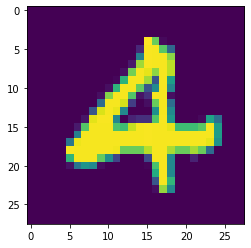

7


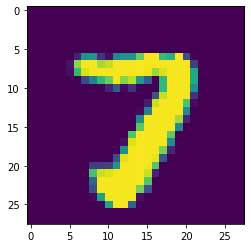

8


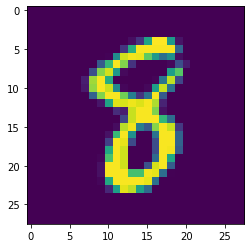

0


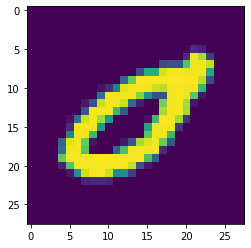

7


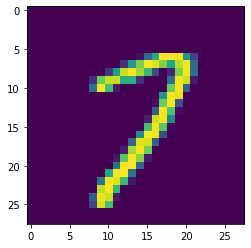

In [8]:
#Visualising images with their according labels for train
show5(train_loader)

7


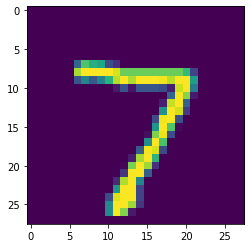

2


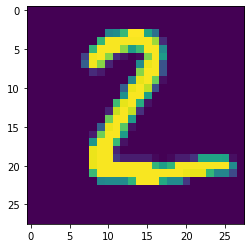

1


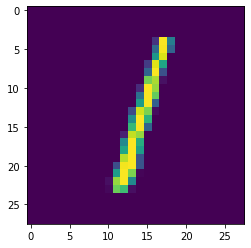

0


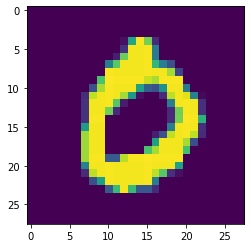

4


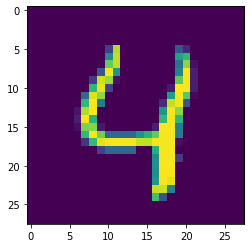

In [9]:
#Visualising images with their according labels for test
show5(test_loader)

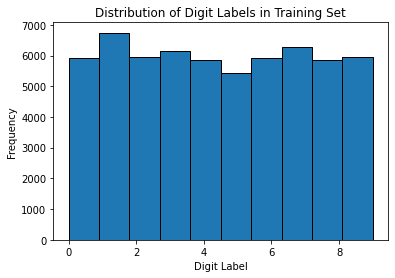

In [10]:
# Ploting distribution of labels
plt.hist(train_dataset.targets.numpy(), bins=10, edgecolor='black')
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.title('Distribution of Digit Labels in Training Set')
plt.show()

## Building my Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), I constructed a neural network based on the parameters of the dataset.


In [11]:
#Defining my neural network class
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)  #First FC layer
        self.fc2 = nn.Linear(128, 128)  #Second FC layer
        self.fc3 = nn.Linear(128, 10)  #Output layer,10 neurons for 10 digits

    def forward(self, x):
        x = self.flatten(x)
        x = F.sigmoid(self.fc1(x))  #Applying sigmoid activation to the first layer
        x = F.sigmoid(self.fc2(x))  #Applying sigmoid activation to the second layer
        x = F.softmax(self.fc3(x), dim=1)  #Applying softmax activation to the output layer
        return x

my_model = MyModel()

Specifying a loss function and an optimizer, and instantiate the model.


In [12]:
#Defining loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(my_model.parameters(), lr=0.001)  #Adam optimiser with learning rate 0.001

## Running my Neural Network
While training my neural network, I ensured to record the average loss at each epoch. 


In [13]:
#Defining my neural network class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  #Flattenning the input images
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)  #Applying Leaky ReLU activation
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)  #Applying Leaky ReLU activation
        x = self.fc3(x)
        return x

#Instantiating the model
net = Net()

Ploting the training loss (and validation loss/accuracy).

Epoch [1/5], Training Loss: 2.3049, Validation Loss: 2.3058, Validation Accuracy: 8.40%
Epoch [2/5], Training Loss: 2.3049, Validation Loss: 2.3058, Validation Accuracy: 8.40%
Epoch [3/5], Training Loss: 2.3049, Validation Loss: 2.3058, Validation Accuracy: 8.40%
Epoch [4/5], Training Loss: 2.3049, Validation Loss: 2.3058, Validation Accuracy: 8.40%
Epoch [5/5], Training Loss: 2.3049, Validation Loss: 2.3058, Validation Accuracy: 8.40%


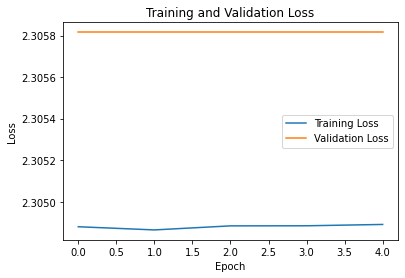

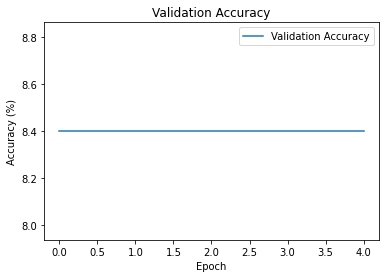

In [14]:
# Define number of epochs
num_epochs = 5

train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimiser.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    #Validation
    net.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_running_loss / len(test_loader)
    val_loss_history.append(avg_val_loss)
    val_acc = 100 * correct / total
    val_acc_history.append(val_acc)

    # Print epoch information
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_acc:.2f}%')

# Plotting
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

## Testing my model
Using the previously created `DataLoader` for the test set, I computed the percentage of correct predictions using the highest probability prediction. 


In [15]:
correct = 0
total = 0

#Setting my model to evaluation mode
my_model.eval()

#Iterating over the test set DataLoader
for images, labels in test_loader:
    # Performing inference
    with torch.no_grad():
        outputs = my_model(images)
    
    #Getting predicted labels
    _, predicted = torch.max(outputs, 1)
    
    #Computing the number of correct predictions
    correct += (predicted == labels).sum().item()
    
    #Updating the total number of examples
    total += labels.size(0)

#Computing percentage of correct predictions
accuracy = correct / total * 100
print(f'Accuracy on the test set: {accuracy:.2f}%')


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy on the test set: 10.10%


## Improving my model

Once my model was done training, I tried tweaking my hyperparameters and training to improve my accuracy on the test set.

In [16]:
# Defining new neural network model
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)#Dropout with 50% probability
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

#Initialising the model, loss function, and optimiser
model = ComplexModel()
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

#Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
        if i % 250 == 249:    #Printing average loss every 250 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 250))
            running_loss = 0.0

print('Finished Training')

#Evaluating the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (
    100 * correct / total))

[1,   250] loss: 1.606
[1,   500] loss: 0.829
[1,   750] loss: 0.645
[2,   250] loss: 0.558
[2,   500] loss: 0.526
[2,   750] loss: 0.490
[3,   250] loss: 0.428
[3,   500] loss: 0.462
[3,   750] loss: 0.420
[4,   250] loss: 0.416
[4,   500] loss: 0.411
[4,   750] loss: 0.401
[5,   250] loss: 0.399
[5,   500] loss: 0.388
[5,   750] loss: 0.385
[6,   250] loss: 0.375
[6,   500] loss: 0.367
[6,   750] loss: 0.359
[7,   500] loss: 0.350
[7,   750] loss: 0.363
[8,   250] loss: 0.337
[8,   500] loss: 0.352
[8,   750] loss: 0.336
[9,   250] loss: 0.347
[9,   500] loss: 0.327
[9,   750] loss: 0.342
[10,   250] loss: 0.330
[10,   500] loss: 0.334
[10,   750] loss: 0.329
Finished Training
Accuracy on the test set: 91 %


## Saving my model
Using `torch.save`, I saved my model for future loading.

In [17]:
# Save the entire model
torch.save(my_model, 'mnist_model.pth')